In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering

/home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering


In [2]:
import pandas as pd
import numpy as np

# Get mutation datasets

## Patent dataset

In [3]:
def get_mutations(raw_muts, sep='+'):
    muts = raw_muts.replace(" ", "").split(sep)
    
    return '/'.join(muts)

In [ ]:
xl_file = pd.ExcelFile('data/round1/hotspots/subtilisin_patents.xls')
df_patents_a = xl_file.parse('Washing_data-a')
df_patents_b = xl_file.parse('Washing_data-b')
print(df_patents_a.columns), print(df_patents_b.columns)
print(len(df_patents_a), len(df_patents_b))
df_patents_a['mutations'] = [get_mutations(raw_muts) for raw_muts in df_patents_a.mutation]
df_patents_a['n_muts'] = [len(muts.split('/')) if '/' in muts else 0 for muts in df_patents_a.mutations]

df_patents_b['mutations'] = [get_mutations(raw_muts) for raw_muts in df_patents_b.mutation]
df_patents_b['n_muts'] = [len(muts.split('/')) if '/' in muts else 0 for muts in df_patents_b.mutations]

df_patents = pd.concat([df_patents_a[['mutations','n_muts']], df_patents_b[['mutations','n_muts']]], join='outer')

print(len(df_patents), df_patents.n_muts.min(), df_patents.n_muts.max())

Index(['source', '申请单位', 'mutation', 'Normalized values', 'performanc',
       '指标的含义', '坐标', '亲本野生型', '其他备注'],
      dtype='object')
Index(['source', '申请单位', 'mutation', 'Normalized values', 'performance',
       '指标的含义', '坐标', '亲本野生型', '其他备注'],
      dtype='object')
349 1234
1583 0 10


## Publication dataset

In [ ]:
publication_file = 'data/round1/hotspots/subtilisin_pub_data_n_muts.csv'

xl_file = pd.ExcelFile('data/round1/hotspots/Subtilisin_pub_data.xls')
df_activity = xl_file.parse('Activity_BPN')


df_activity['mutations'] = [get_mutations(raw_muts, sep='/') for raw_muts in df_activity['Mutations']]
df_activity['n_muts'] = [len(muts.split('/')) if muts != 'wild-type' else 0 for muts in df_activity.mutations]

print(df_activity.columns)
df_activity[['mutations','n_muts']].to_csv(publication_file, index=False)

len(df_activity)

Index(['Mutations', 'Score', 'kcat/Km(s-1 mM-1)', '(U/min*mg)', 'Temp (°C)',
       'Substrate (AAPF, Casein)', 'Ref', 'Source', 'Paper', 'mutations',
       'n_muts'],
      dtype='object')


273

# Mutaiton frequencies

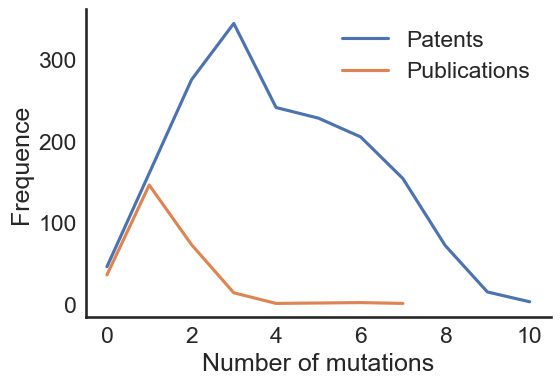

In [12]:
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")

fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

df_patents.groupby(['n_muts']).size().plot(label='Patents', ax=ax)
df_activity.groupby(['n_muts']).size().plot(ax=ax, label='Publications')

ax.set_xlabel('Number of mutations')
ax.set_ylabel('Frequence')
ax.legend(frameon=False)
plot_style_utils.save_for_pub(fig, path='figures/round1/hotspot_r1_n_mutations')

# Prioritize positions

In [14]:
from collections import Counter
from itertools import islice

def get_mut2count(df):
    mut2count = Counter([mut for muts in df.mutations for mut in muts.split('/')])
    dict_mut2count = {k: v for k, v in sorted(mut2count.items(), key=lambda item: item[1], reverse=True)}
    df_mut2count = pd.DataFrame({'mutation': list(dict_mut2count.keys()), 'counts': list(dict_mut2count.values())})
    df_mut2count = df_mut2count[df_mut2count.mutation != 'wild-type']

    df_mut2count['pos']  = [mut[1:-1] for mut in df_mut2count.mutation]  # for postion analysis

    print(df_mut2count.counts.min(), df_mut2count.counts.max(), df_mut2count.counts.median())
    return df_mut2count


def get_pos2mut_count(df):
    df_mut2count = get_mut2count(df)
    pos2count = Counter([mut[1:-1] for mut in df_mut2count.mutation])
    pos2mut_count = {k: v for k, v in sorted(pos2count.items(), key=lambda item: item[1], reverse=True)}

    df_pos2mut = pd.DataFrame({'pos': pos2mut_count.keys(), 'n_muts': pos2mut_count.values()})
    df_pos2mut['muts'] = [list(df_mut2count[df_mut2count.pos == pos].mutation) for pos in df_pos2mut.pos]
    df_pos2mut['n_mutants'] = [df_mut2count[df_mut2count.pos == pos].counts.sum() for pos in df_pos2mut.pos]
    df_pos2mut['muts_ratios'] = [[round(ratio, 3) for ratio in df_mut2count[df_mut2count.pos == pos].counts.values / 
                                  df_mut2count[df_mut2count.pos == pos].counts.sum()]  for pos in df_pos2mut.pos]
    
    df_pos2mut.sort_values('n_mutants', ascending=False, inplace=True,)
    return df_pos2mut, df_mut2count


In [ ]:
df_pat_pos2mut, df_pat_mut2count = get_pos2mut_count(df_patents)
df_pat_pos2mut.to_csv('data/round1/hotspots/subtilisin_patents_pos2muts.csv')
df_pat_mut2count.to_csv('data/round1/hotspots/subtilisin_patents_mut2count.csv')
display(df_pat_pos2mut.head()), display(df_pat_mut2count.head())

1 721 3.0


,pos,n_muts,muts,n_mutants,muts_ratios
10,9,8,"[S9R, S9G, S9K, S9L, S9V, S9F, S9M, S9D]",746,"[0.966, 0.011, 0.005, 0.005, 0.005, 0.004, 0.0..."
0,245,16,"[Q245R, Q245W, Q245F, Q245G, Q245E, Q245V, Q24...",542,"[0.566, 0.103, 0.052, 0.041, 0.037, 0.033, 0.0..."
45,15,3,"[A15T, A15M, A15L]",529,"[0.97, 0.028, 0.002]"
46,62,3,"[N62D, N62E, N62S]",368,"[0.984, 0.011, 0.005]"
18,68,5,"[V68A, V68S, V68L, V68I, V681]",288,"[0.927, 0.028, 0.028, 0.014, 0.003]"


,mutation,counts,pos
0,S9R,721,9
1,A15T,513,15
2,N62D,362,62
3,Q245R,307,245
4,V68A,267,68


(None, None)

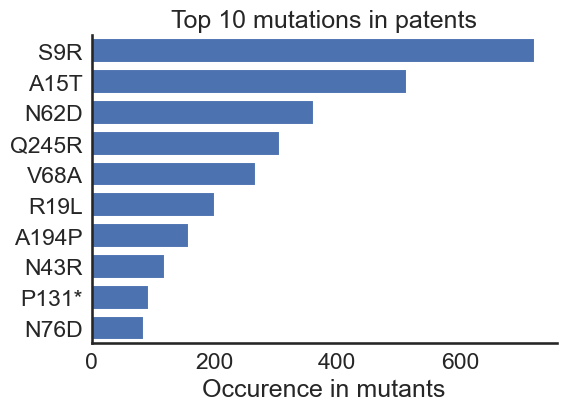

In [19]:
from utils import plot_style_utils
topn=10

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

df_topn_mutations = df_pat_mut2count.nlargest(topn, 'counts')# .mutation

ax.barh(df_topn_mutations.mutation[::-1], df_topn_mutations.counts[::-1], )
ax.set_yticks(df_topn_mutations.mutation[::-1])
ax.set_yticklabels(df_topn_mutations.mutation[::-1])
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel('Occurence in mutants')
ax.set_title(f'Top {topn} mutations in patents')
plot_style_utils.save_for_pub(fig, path=f'figures/round1/hotspot_patent_top_{topn}_mutations')

In [ ]:
df_pub_pos2mut, df_pub_mut2count = get_pos2mut_count(df_activity)
# df_pub_pos2mut.to_csv('data/round1/hotspots/Subtilisin_pub_data_pos2muts.csv')
# df_pub_mut2count.to_csv('data/round1/hotspots/Subtilisin_pub_data_mut2count.csv')
df_pub_pos2mut.head()

1 26 1.0


,pos,n_muts,muts,n_mutants,muts_ratios
1,166,8,"[G166D, G166N, G166K, G166E, G166Q, G166M, G16...",70,"[0.371, 0.171, 0.171, 0.057, 0.057, 0.057, 0.0..."
12,156,2,"[E156S, E156Q]",35,"[0.543, 0.457]"
0,222,20,"[M222S, M222A, M222G, M222V, M222F, M222C, M22...",30,"[0.133, 0.1, 0.067, 0.067, 0.067, 0.067, 0.067..."
21,62,1,[N62D],24,[1.0]
22,24,1,[S24C],16,[1.0]


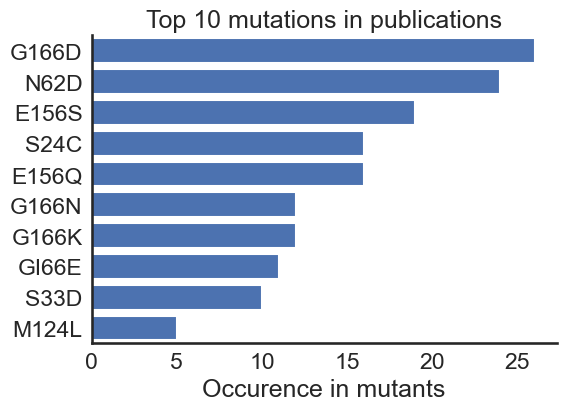

In [20]:
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

df_topn_mutations = df_pub_mut2count.nlargest(topn, 'counts')# .mutation

ax.barh(df_topn_mutations.mutation[::-1], df_topn_mutations.counts[::-1], )
ax.set_yticks(df_topn_mutations.mutation[::-1])
ax.set_yticklabels(df_topn_mutations.mutation[::-1])
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel('Occurence in mutants')
ax.set_title(f'Top {topn} mutations in publications')
plot_style_utils.save_for_pub(fig, path=f'figures/round1/hotspot_pub_top_{topn}_mutations')

# Obtain hotspots

## Analyze the mutations as following in Excel:
1. Find the common mutation positions both occur in publications & patents
2. Remove the positions/mutations known to decrease activity according to publication dataset

In [21]:
pub_opt_muts = [['Q2L', 'Q2K'], 
['S3T', 'S3A', 'S3L', 'S3Y', 'S3V', 'S3T', 'S3C'], 
['S24P', 'S24C'], 
['N43R', 'N43D', 'N43S', 'N43E', 'K43N'], 
['F50S', 'M50F', 'M50V'], 
['N76D', 'N76S', 'N76D'], 
['A98S', 'A98T', 'A98L', 'A98G', 'A98R', 'A98E', 'A98D', 'A98M', 'A98Q', 'A98N', 'A98V', 'A98C', 'A98K'], 
['I107V', 'I107T', 'I107M', 'I107G', 'I107V', 'I107A'], 
['L124I', 'L124C', 'M124L', 'M124I'], 
['S125A', 'S125G', 'S125A'], 
['L126I', 'L126F', 'L126V', 'L126A', 'L126G', 'L126C'], 
['P131*', 'P131H', 'P131S', 'P131F', 'P131T', 'P131M', 'P131A', 'P131Q', 'P131W', 'P131R', 'Q131H', 'P131L', 'P131D', 'P131C', 'G131D'], 
['A152P', 'A152C', 'A152S'], 
['A169G', 'G169A'], 
['N204D', 'N204S', 'N204T', 'S204F'], 
['Q206L', 'Q206C', 'Q206P', 'Q206E', 'Q206K'], 
['Y209H', 'Y209C', 'L209F'], 
['T213A', 'K213R', 'K213E', 'K213V', 'K213Y'], 
['L217D', 'Y217L', 'Y217M', 'Y217K', 'Y217A', 'Y217C', 'Y217V', 'Y217G'], 
['N218D', 'N218S', 'N218S', 'N218T', 'N218A', 'N218H'], 
['M222S', 'M222V', 'M222S', 'M222A', 'M222G', 'M222V', 'M222F', 'M222C', 'M222L', 'M222T', 'M222N', 'M222P', 'M222Q', 'M222W', 'M222D', 'M222Y', 'M222H', 'M222E', 'M222I', 'M222R', 'M222K'], 
['A223G', 'A223S'], 
['T224A', 'T224S', 'S224A', 'S224C'], 
['S256N', 'S256G', 'S256R', 'K256Y'], 
['E271A', 'Q271E'], ]

In [22]:
def is_pos_match(pos, mut):
    return pos == int(mut[1:-1])

def get_pos2mut(muts):
    pos = int(muts[0][1:-1])
    mut_aas = []
    for mut in muts:
        if not is_pos_match(pos, mut):
            raise Exception(f'error: {mut} is not in postion {pos}!')
        mut_aas.append(mut[-1])
    
    return pos, list(set(mut_aas) - set('*'))

def get_dict_pos2mut_aas(opt_muts):
    pos2mut_dict = {}
    for pos_muts in opt_muts:
        pos, muts = get_pos2mut(pos_muts) 
        pos2mut_dict[pos] = muts

    # add BPN wild-type AA into positions
    subtilisin_BPN = 'AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGGASMVPSETNPFQDNNSHGTHVAGTVAALNNSIGVLGVAPSASLYAVKVLGADGSGQYSWIINGIEWAIANNMDVINMSLGGPSGSAAL' \
        'KAAVDKAVASGVVVVAAAGNEGTSGSSSTVGYPGKYPSVIAVGAVDSSNQRASFSSVGPELDVMAPGVSIQSTLPGNKYGAYNGTSMASPHVAGAAALILSKHPNWTNTQVRSSLENTTTKLGDSFYYGKGLINVQAAAQ'
    for pos in pos2mut_dict.keys():
        if subtilisin_BPN[pos-1] not in pos2mut_dict[pos]:
            pos2mut_dict[pos].append(subtilisin_BPN[pos-1])
    
    size_search_space_log = np.sum([np.log(len(val)) for key, val in pos2mut_dict.items()])

    print(f'number of positions: {len(pos2mut_dict.keys())}, search space size: {np.exp(size_search_space_log):.2e}')

    return pos2mut_dict

## Get mutations in each position and estimate search space size

In [ ]:
pos2mut_aa = get_dict_pos2mut_aas(pub_opt_muts)

df_hotspot = pd.DataFrame({'pos': list(pos2mut_aa.keys()), 'mut_aas': list(pos2mut_aa.values())})
df_hotspot.to_csv('data/round1/hotspots/Subtilisin_BPN_hotspot.csv', index=False)

number of positions: 25, search space size: 2.80e+17


# Visualize hospot as heatmap

In [ ]:
import pandas as pd

df_hotspot = pd.read_csv('data/round1/hotspots/Subtilisin_BPN_hotspot.csv')
print(len(df_hotspot))
df_hotspot.head()

25


,pos,mut_aas
0,2,"['K', 'L', 'Q']"
1,3,"['C', 'V', 'A', 'Y', 'L', 'T', 'S']"
2,24,"['C', 'P', 'S']"
3,43,"['R', 'N', 'E', 'D', 'S', 'K']"
4,50,"['F', 'V', 'S', 'M']"


In [25]:
NAT_AAS = list("ACDEFGHIKLMNPQRSTVWY")

df_heatmap = pd.DataFrame(index=df_hotspot.pos, columns=NAT_AAS, data=0)
for pos, mut_aas in zip(df_hotspot.pos, df_hotspot.mut_aas):
    for mut_aa in mut_aas:
        if mut_aa in NAT_AAS:
            df_heatmap.loc[pos, mut_aa] = 1
df_heatmap = df_heatmap.astype(int)
df_heatmap['pos'] = df_heatmap.index
df_heatmap = df_heatmap.reset_index(drop=True)
# transpose the dataframe for better visualization
df_heatmap = df_heatmap.set_index('pos').T
df_heatmap.head()

pos,2,3,24,43,50,76,98,107,124,125,...,206,209,213,217,218,222,223,224,256,271
A,0,1,0,0,0,0,1,1,0,1,...,0,0,1,1,1,1,1,1,0,1
C,0,1,1,0,0,0,1,0,1,0,...,1,1,0,1,0,1,0,1,0,0
D,0,0,0,1,0,1,1,0,0,0,...,0,0,0,1,1,1,0,0,0,0
E,0,0,0,1,0,0,1,0,0,0,...,1,0,1,0,0,1,0,0,0,1
F,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


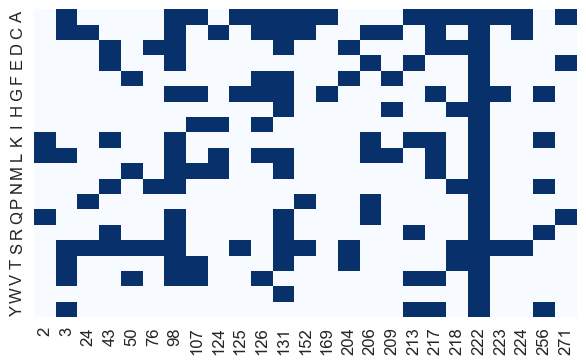

In [26]:
import matplotlib.pyplot as plt
from utils import plot_style_utils
import seaborn as sns

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax(figsize=(7, 4))
plot_style_utils.prettify_ax(ax)

sns.heatmap(df_heatmap, cmap='Blues', cbar=False, ax=ax) # Label for the color bar

# show AAs on the y-axis
ax.set_yticks([x + 0.5 for x in range(len(df_heatmap.index))])  # Set y-ticks to the middle of each row
ax.set_yticklabels(df_heatmap.index, fontsize=12,)  # Set y-t

ax.set_xticks([x+0.5 for x in range(len(df_heatmap.columns))])
ax.set_xticklabels(df_heatmap.columns, rotation=90, fontsize=12) # Set x-tick labels to the positions

ax.set_xlabel('')
ax.set_ylabel('')

plt.xticks(rotation=90) # Rotate x-axis labels for better readability if many positions

plot_style_utils.save_for_pub(fig, path='figures/round1/hotspot_r1_mutation_heatmap')